In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from IPython.display import HTML

from data_funcs_and_classes import AnimatedScatter, generate_data, UMIDataset
from model_classes import UMINN, UMINN_SVB, UMINN_SVB_Soft

C:\Users\aslak\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data, labels = generate_data()

loader = DataLoader(UMIDataset(torch.from_numpy(data), torch.from_numpy(labels)), batch_size=32, shuffle=True)

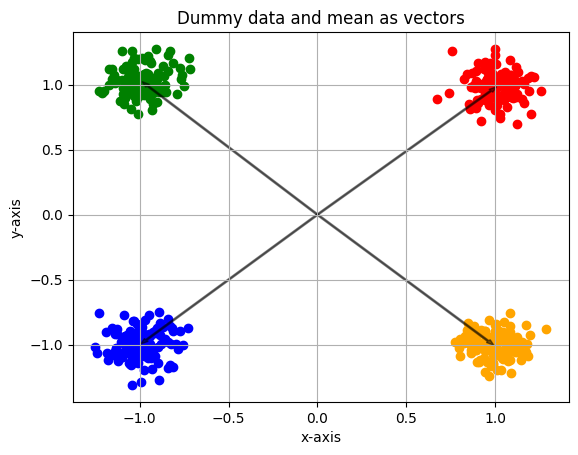

In [3]:
plt.close()
fig, ax = plt.subplots(1)#, sharex='col', sharey='row', gridspec_kw={'wspace': 0})

colors = ['red','green','blue','orange']
means = np.mean(np.reshape(data,(4,int(data.shape[0]/4),data.shape[-1])),axis=1)
cluster_N = int(data.shape[0] / 4)
for color,mean,i in zip(colors,means,range(len(colors))):
    ax.scatter(data[i*cluster_N:(i+1)*cluster_N,0],data[i*cluster_N:(i+1)*cluster_N,1],color=color)
    ax.arrow(0,0,mean[0],mean[1],length_includes_head=True,width=0.01,color=(0,0,0,0.5))
plt.title('Dummy data and mean as vectors')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
ax.grid('on')

In [4]:
def train(dl, model, lr = 0.01, n_epochs = 2, svb = False):
    losses = []
    epochs = []
    weights = []
    
    for epoch in range(n_epochs):
        #print(f"Epoch {epoch+1}")
        N = len(loader)
        for param in model.parameters():
            weights.append(param.detach().numpy().copy())
        for i, (data, labels) in enumerate(loader):
            epochs.append(epoch + i/N)
            loss_data = model.train_step(data, labels)
            losses.append(loss_data)
        if svb:
            model.svb
    return losses, epochs, weights

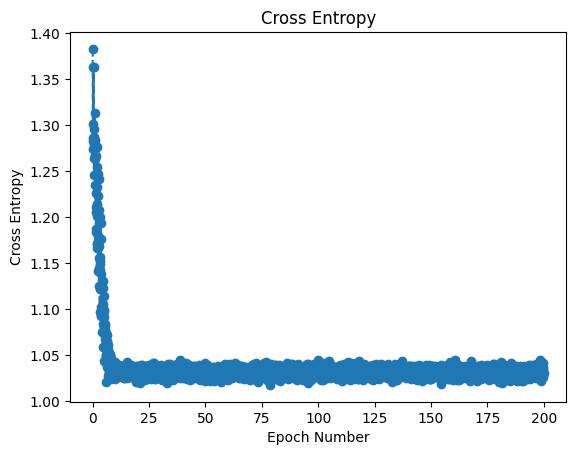

In [5]:
model = UMINN_SVB_Soft()
lr = 0.01
n_epochs = 200
losses, epochs, weights = train(loader, model, lr, n_epochs)

plt.plot(epochs, losses, 'o--')
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
_ = plt.title('Cross Entropy')

In [6]:
print(weights[-1])

[[ 0.8151222   0.7966297 ]
 [-0.7886397   0.79142207]
 [-0.8004513  -0.78753   ]
 [ 0.7741492  -0.8011361 ]]


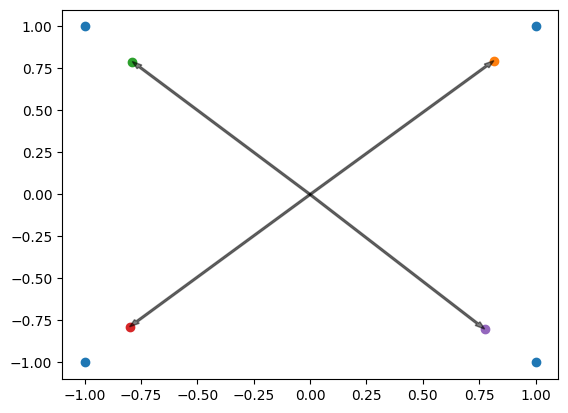

In [7]:
plt.scatter([-1, -1, 1, 1], [1, -1, 1, -1])
for point in weights[-1]:
    plt.scatter(point[0], point[1])
    plt.arrow(0, 0, point[0], point[1], length_includes_head=True,width=0.01,color=(0,0,0,0.5))

In [8]:
test_data, test_labels = generate_data()
#print(model(torch.tensor(test_data)).argmax(dim=1))
#print(torch.tensor(test_labels))
acc = (model(torch.tensor(test_data)).argmax(dim=1) == torch.tensor(test_labels)).float().sum().item()/len(test_labels)
print(acc)

1.0


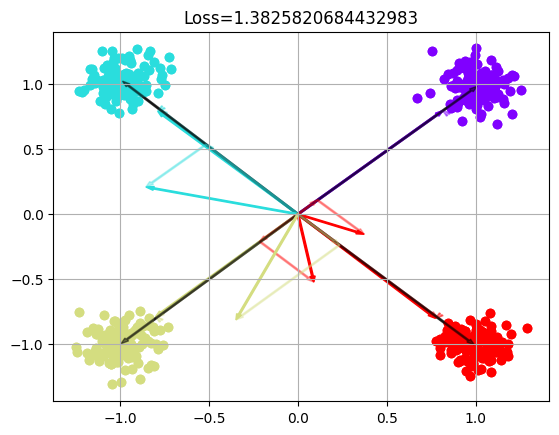

In [9]:
animated_scatter = AnimatedScatter(data, np.array(weights).transpose([0, 2, 1]), losses[::16], n_clusters = 4)
html_object = HTML(animated_scatter.animation.to_html5_video())
html_object